# PROJECT


## Import libraries


In [1]:
# Import custom helper libraries
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

import features.helpers as feat_helpers
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()  
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")
TRANSLATOR_TEXT_SUBSCRIPTION_KEY= os.getenv("TRANSLATOR_TEXT_SUBSCRIPTION_KEY")
TRANSLATOR_TEXT_ENDPOINT=os.getenv("TRANSLATOR_TEXT_ENDPOINT")
TRANSLATOR_TEXT_LOCATION=os.getenv("TRANSLATOR_TEXT_LOCATION")


# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# System modules
import time
import random
import requests
from hashlib import md5
import json


# ML modules
import pandas as pd
import numpy as np


# Viz modules
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Sample data for development
TEXT_SAMPLE_SIZE = 10*1000 # <= 0 for all
PHOTO_SAMPLE_SIZE = 10*1000 # <= 0 for all

## Text data

### Load reviews

In [119]:
# Load academic data

if os.path.exists("../data/processed/academic/reviews.pkl.gz"):
    # Load academic data from pickle file
    logger.info(">>> Loading reviews from pickle file...")
    reviews_df = pd.read_pickle("../data/processed/academic/reviews.pkl.gz")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from pickle file.")
else:
    # Load academic data from row CSV file
    logger.info(">>> Loading reviews from JSON file...")
    reviews_df = pd.DataFrame()
    with pd.read_json(
        "../data/raw/academic/yelp_academic_dataset_review.json",
        dtype={
            "review_id": str,
            "user_id": str,
            "business_id": str,
            "stars": int,
            "useful": int,
            "funny": int,
            "cool": int,
            "text": str,
            "date": "datetime64[ns]",
        },
        chunksize=500 * 1000,
        lines=True,
    ) as json_reader:
        # Load data in chunks
        for chunk in json_reader:
            reviews_df = reviews_df.append(chunk)
            logger.info(f"Loaded {len(reviews_df)} reviews")
    logger.info(f">>> OK : {len(reviews_df)} reviews loaded from JSON file.")

    # Reduce memory usage
    reviews_df = data_helpers.reduce_dataframe_memory_usage(reviews_df)

    # Save as pickle
    logger.info(">>> Saving reviews data as pickle file...")
    os.makedirs("../data/processed/academic/", exist_ok=True)
    reviews_df.to_pickle("../data/processed/academic/reviews.pkl.gz")
    logger.info(
        ">>> OK : Reviews data saved to ../data/processed/academic/reviews.pkl.gz ."
    )

if TEXT_SAMPLE_SIZE > 0:
    # Sample data
    logger.info(">>> Sampling reviews data...")
    reviews_df = reviews_df.sample(TEXT_SAMPLE_SIZE, random_state=42)
    logger.info(f">>> OK : Data sampled to {len(reviews_df)} reviews.")


INFO:__main__:>>> Loading reviews from pickle file...


KeyboardInterrupt: 

### Exploratory Data Analysis


In [ ]:
reviews_df.describe(include="all", datetime_is_numeric=True)


In [ ]:
# Number of reviews per user
reviews_per_user = reviews_df.groupby("user_id").count()["review_id"]

fig = px.histogram(
    reviews_per_user,
    title=f"Number of reviews per user (N={len(reviews_df)})",
    log_y=True,
    histnorm="probability density",
)
fig.update_layout(
    xaxis_title_text='Number of reviews',
    yaxis_title_text='Ratio of users (log)',
)
fig.show()


In [ ]:
# Number of reviews per business
reviews_per_business = reviews_df.groupby("business_id").count()["review_id"]

fig = px.histogram(
    reviews_per_user,
    title=f"Number of reviews per business (N={len(reviews_df)})",
    log_y=True,
    histnorm="probability density",
)
fig.update_layout(
    xaxis_title_text="Number of reviews",
    yaxis_title_text="Ratio of businesses (log)",
)
fig.show()


In [ ]:
fig = px.histogram(
    reviews_df.sample(1000, random_state=42),
    x="stars",
    title=f"Reviews by Stars (N={len(reviews_df)}, n=1000)",
    marginal="box",
    histnorm='probability',
)
fig.show()


In [ ]:
fig = px.histogram(
    reviews_df[["useful", "funny", "cool"]],
    title=f"Useful / Funny / Cool score per review (N={len(reviews_df)})",
    log_y=True,
    histnorm="probability density",
    barmode="stack",
)
fig.update_layout(
    xaxis_title_text="Useful / Funny / Cool score",
    yaxis_title_text="Ratio of reviews (log)",
)
fig.show()


In [ ]:
# Reviews language
if False:
    reviews_df["language"] = reviews_df["text"].apply(
        lambda x: feat_helpers.detect_language(
            x,
            TRANSLATOR_TEXT_SUBSCRIPTION_KEY,
            TRANSLATOR_TEXT_ENDPOINT,
            TRANSLATOR_TEXT_LOCATION,
        )
    )


### Reviews sentiment analysis


#### Define the corpus and target variable

In [ ]:
from sklearn.model_selection import train_test_split


X = reviews_df["text"]
y = reviews_df["stars"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Sentiment analysis : binary classification
y_bi = [0 if x < 5 else 1 for x in y]
y_train_bi = [0 if x < 5 else 1 for x in y_train]
y_test_bi = [0 if x < 5 else 1 for x in y_test]


#### Define the feature extraction models


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


tokenizers = {
    "None": None,
    "stopwords": lambda text: [
        token.lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "PorterStemmer": lambda text: [
        PorterStemmer().stem(token).lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "WordNetLemmatizer": lambda text: [
        WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
        for token, pos in pos_tag(word_tokenize(text))
        if token.isalpha() and token.lower() not in stopwords
    ],
    "SpaCy": lambda text: [
        token.lemma_.lower()
        for token in nlp(text)
        if token.is_alpha and not token.is_stop
    ],
}


vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer(),
    "CountVectorizer + strip_accents + lowercase": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "TfidfVectorizer + strip_accents + lowercase": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
}

for tokenizer_name, tokenizer in tokenizers.items():
    vectorizers[
        f"CountVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )
    vectorizers[
        f"TfidfVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )


In [ ]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation


def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    n_cols = 5
    n_lines = int(np.ceil(min(n_topics, model.n_components) / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0:n_topics]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


n_components = 100
for vectorizer_name in [
    "TfidfVectorizer + strip_accents + lowercase",
    "TfidfVectorizer + strip_accents + lowercase + stop_words",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + stopwords",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + PorterStemmer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + WordNetLemmatizer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy",
]:
    vectorizer = vectorizers[vectorizer_name]
    X_vec = vectorizer.fit_transform(X)

    words_count = pd.Series(
        X_vec.sum(axis=0).tolist()[0],
        index=vectorizer.get_feature_names(),
    )

    top_20_count = words_count.sort_values(ascending=False).head(20)

    fig = px.bar(
        top_20_count,
        x=top_20_count.index,
        y=top_20_count.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_count.values,
    )
    fig.show()

    lsa = TruncatedSVD(n_components=n_components, random_state=42).fit(X_vec)
    # X_lsa = lsa.transform(X_vec)

    # fig = px.line(
    #     x=range(1, n_components + 1),
    #     y=np.cumsum(lsa.explained_variance_ratio_),
    #     labels={
    #         "x": "Principal Component",
    #         "y": "Explained Variance Ratio",
    #     },
    #     title=f"{vectorizer_name} : Explained Variance Ratio",
    # )
    # fig.show()

    # fig = px.scatter_3d(
    #     X_lsa,
    #     x=X_lsa[:, 0],
    #     y=X_lsa[:, 1],
    #     z=X_lsa[:, 2],
    #     labels={"x": "Component 1", "y": "Component 2", "z": "Component 3"},
    #     title=f"{vectorizer_name} : SVD",
    #     color=y,
    #     opacity=0.5,
    # )
    # fig.show()

    plot_top_words(
        model=lsa,
        feature_names=vectorizer.get_feature_names(),
        n_top_words=10,
        n_topics=10,
        title=f"{vectorizer_name} : LSA",
    )


## Photos


In [2]:
photos_df = pd.DataFrame()
with pd.read_json(
    "../data/raw/academic/photos.json",
    chunksize=500 * 1000,
    lines=True,
) as json_reader:
    # Load data in chunks
    for chunk in json_reader:
        photos_df = photos_df.append(chunk)
        logger.info(f"Loaded {len(photos_df)} photos")
logger.info(f">>> OK : {len(photos_df)} photos loaded from JSON file.")

# Reduce memory usage
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)


INFO:__main__:Loaded 200000 photos
INFO:__main__:>>> OK : 200000 photos loaded from JSON file.
INFO:root:Memory usage of dataframe is 6.1 MB
INFO:root:Memory usage after optimization is 4.77 MB
INFO:root:Decreased by 22 %


In [3]:
photos_df.describe(include="all")

photo_id             business_id caption   label
count                   200000                  200000  200000  200000
unique                  199999                   39438   86333       5
top     luJ6-yFuJCZzjUYDQu9Dhw  4CxF8c3MB7VAdY8zFb2cZQ           drink
freq                         2                     493   88090   40000

In [4]:
px.histogram(
    photos_df,
    x="label",
    # color="label",
    histnorm="probability",
    title=f"Photos distribution by label (N={len(photos_df)})",
)

In [5]:
if PHOTO_SAMPLE_SIZE > 0:
    sampled_photos_df = pd.DataFrame()
    for label in photos_df.label.unique():
        sampled_photos_df = sampled_photos_df.append(
            photos_df[photos_df.label == label].sample(
                int(PHOTO_SAMPLE_SIZE / (len(photos_df.label.unique()))),
                random_state=42,
            )
        )
else:
    sampled_photos_df = photos_df

sampled_photos_df.describe(include="all")


photo_id             business_id caption  label
count                    10000                   10000   10000  10000
unique                   10000                    7444    4913      5
top     z6-4XQmfKuBuQ0GLVtJerA  4CxF8c3MB7VAdY8zFb2cZQ          drink
freq                         1                      22    4369   2000

In [7]:
import cv2 as cv
from sklearn.feature_extraction.image import extract_patches_2d

photos_features_df = pd.DataFrame()
for photo in sampled_photos_df.itertuples():
    if random.random() < 0.001:
        print(len(photos_features_df))

    img_path = os.path.join(
        "../data/raw/academic/photos", f"{photo.photo_id}.jpg"
    )
    img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    color_descriptors = []
    for patch in extract_patches_2d(
        img,
        patch_size=(20, 20),
        max_patches=200,
        random_state=42,
    ):
        color_descriptors.append(
            cv.calcHist(
                [
                    cv.cvtColor(patch, cv.COLOR_BGR2RGB),
                    cv.cvtColor(patch, cv.COLOR_BGR2HSV),
                    cv.cvtColor(patch, cv.COLOR_BGR2LAB),
                ],
                [0, 1, 2],
                None,
                [5, 5, 5],
                [0, 256, 0, 256, 0, 256],
            ).flatten()
        )

    # ORB Features
    orb = cv.ORB_create(nfeatures=200)
    orb_keypoints = orb.detect(img_gray, None)
    orb_keypoints, orb_descriptors = orb.compute(img_gray, orb_keypoints)

    photos_features_df = photos_features_df.append(
        {
            "file_name": photo.photo_id,
            "label": photo.label,
            "color_descriptors": color_descriptors,
            "orb_keypoints": orb_keypoints,
            "orb_descriptors": orb_descriptors,
        },
        ignore_index=True,
    )

photos_features_df.dropna(inplace=True)
photos_features_df


279
310
391
597
1692
2737
5965
7924
8928


file_name  label  \
0     z6-4XQmfKuBuQ0GLVtJerA  drink   
1     5Sz1hsnhT8FYzdUzWw-yGA  drink   
2     TtltNsdo0xkEOQrLMdGimQ  drink   
3     hBpRETEuwmzwiQnbV9A14w  drink   
4     D5qbaIRKiY7UyehfE9428A  drink   
...                      ...    ...   
9995  hN8wuUwrNgn7ubt1UfYpMQ   menu   
9996  HvRgIPeZ6fViwRENVYp1-Q   menu   
9997  LIb1H9U4sKEhjBI4c2bKkg   menu   
9998  BXt_kv38g6tizV4Jt9f0Aw   menu   
9999  FdzmIOzug45yZVxsnIy5pQ   menu   

                                      color_descriptors  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
9995  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9996  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9998  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9999  [[8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                          orb_keypoints  \
0     (<KeyPoint 0x7f3ec42f83f0>, <KeyPoint 0x7f3ec4...   
1     (<KeyPoint 0x7f3ec4535d20>, <KeyPoint 0x7f3ec4...   
2     (<KeyPoint 0x7f3ec468cb10>, <KeyPoint 0x7f3ec4...   
3     (<KeyPoint 0x7f3ec47c5db0>, <KeyPoint 0x7f3ec4...   
4     (<KeyPoint 0x7f3ecc069060>, <KeyPoint 0x7f3ecc...   
...                                                 ...   
9995  (<KeyPoint 0x7f3e99558330>, <KeyPoint 0x7f3e99...   
9996  (<KeyPoint 0x7f3e99502e40>, <KeyPoint 0x7f3e99...   
9997  (<KeyPoint 0x7f3e99502c60>, <KeyPoint 0x7f3e99...   
9998  (<KeyPoint 0x7f3e99502c00>, <KeyPoint 0x7f3e99...   
9999  (<KeyPoint 0x7f3e995176c0>, <KeyPoint 0x7f3e99...   

                                        orb_descriptors  
0     [[88, 176, 188, 240, 169, 237, 84, 151, 171, 1...  
1     [[178, 35, 162, 158, 203, 145, 189, 105, 155, ...  
2     [[216, 16, 255, 225, 166, 106, 121, 23, 237, 9...  
3     [[196, 162, 152, 225, 160, 46, 121, 29, 42, 19...  
4     [[195, 232, 183, 243, 168, 172, 40, 150, 190, ...  
...                                                 ...  
9995  [[15, 170, 163, 177, 181, 167, 235, 210, 22, 7...  
9996  [[57, 86, 107, 237, 118, 6, 235, 112, 84, 72, ...  
9997  [[184, 51, 90, 96, 82, 138, 115, 80, 49, 5, 10...  
9998  [[25, 38, 100, 159, 229, 190, 255, 30, 219, 21...  
9999  [[216, 220, 55, 252, 7, 64, 117, 55, 149, 22, ...  

[9999 rows x 5 columns]

In [8]:
color_features = [desc for photo_color in photos_features_df["color_descriptors"] for desc in photo_color]
color_features


[array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  15.,   0.,   0.,   0.,   0.,  62., 317.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.], dtype=float32),
 array([ 78.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  

In [9]:
from sklearn.preprocessing import StandardScaler


color_scaler = StandardScaler().fit(color_features)
color_features_std = color_scaler.transform(color_features)


In [10]:
from sklearn.cluster import KMeans, MiniBatchKMeans


scores = pd.DataFrame(columns=["n_clusters", "inertia"])
for n_clusters in np.logspace(start=1, stop=8, base=2, num=20, dtype=int):
    logger.info(f">>> Clustering with {n_clusters} clusters...")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(
        color_features_std
    )
    logger.info(f">>> OK : inertia={kmeans.inertia_}")
    scores = scores.append(
        {
            "n_clusters": n_clusters,
            "inertia": kmeans.inertia_,
        },
        ignore_index=True,
    )

# Elbow method to select the best number of clusters
fig = px.line(
    scores, x="n_clusters", y="inertia", title="Average clusters inertia"
)
fig.show()


INFO:__main__:>>> Clustering with 4 clusters...
INFO:__main__:>>> OK : inertia=245635396.28405598
INFO:__main__:>>> Clustering with 4 clusters...
INFO:__main__:>>> OK : inertia=245635396.28405598
INFO:__main__:>>> Clustering with 6 clusters...
INFO:__main__:>>> OK : inertia=241035045.10301036
INFO:__main__:>>> Clustering with 7 clusters...
INFO:__main__:>>> OK : inertia=242058963.47049487
INFO:__main__:>>> Clustering with 9 clusters...
INFO:__main__:>>> OK : inertia=238109276.3128667
INFO:__main__:>>> Clustering with 11 clusters...
INFO:__main__:>>> OK : inertia=232177672.15991014
INFO:__main__:>>> Clustering with 14 clusters...
INFO:__main__:>>> OK : inertia=227540393.74559608
INFO:__main__:>>> Clustering with 18 clusters...
INFO:__main__:>>> OK : inertia=230800678.44421864
INFO:__main__:>>> Clustering with 23 clusters...
INFO:__main__:>>> OK : inertia=218919351.1869677
INFO:__main__:>>> Clustering with 28 clusters...
INFO:__main__:>>> OK : inertia=217769508.0331268
INFO:__main__:>>> 

In [13]:
from sklearn.cluster import KMeans, MiniBatchKMeans


n_color_features = 50
color_kmeans = MiniBatchKMeans(n_clusters=n_color_features, random_state=42).fit(
    color_features_std
)

photos_features_df["color_clusters"] = [
    color_kmeans.predict(color_scaler.transform(desc))
    for desc in photos_features_df["color_descriptors"]
]

for cluster in range(n_color_features):
    photos_features_df[f"color_cluster_{cluster}"] = 0

    for i, photo in photos_features_df.iterrows():
        photos_features_df.loc[i, f"color_cluster_{cluster}"] = list(
            photos_features_df.loc[i, "color_clusters"]
        ).count(cluster)

photos_features_df


file_name  label  \
0     z6-4XQmfKuBuQ0GLVtJerA  drink   
1     5Sz1hsnhT8FYzdUzWw-yGA  drink   
2     TtltNsdo0xkEOQrLMdGimQ  drink   
3     hBpRETEuwmzwiQnbV9A14w  drink   
4     D5qbaIRKiY7UyehfE9428A  drink   
...                      ...    ...   
9995  hN8wuUwrNgn7ubt1UfYpMQ   menu   
9996  HvRgIPeZ6fViwRENVYp1-Q   menu   
9997  LIb1H9U4sKEhjBI4c2bKkg   menu   
9998  BXt_kv38g6tizV4Jt9f0Aw   menu   
9999  FdzmIOzug45yZVxsnIy5pQ   menu   

                                      color_descriptors  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
9995  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9996  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9998  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9999  [[8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                          orb_keypoints  \
0     (<KeyPoint 0x7f3ec42f83f0>, <KeyPoint 0x7f3ec4...   
1     (<KeyPoint 0x7f3ec4535d20>, <KeyPoint 0x7f3ec4...   
2     (<KeyPoint 0x7f3ec468cb10>, <KeyPoint 0x7f3ec4...   
3     (<KeyPoint 0x7f3ec47c5db0>, <KeyPoint 0x7f3ec4...   
4     (<KeyPoint 0x7f3ecc069060>, <KeyPoint 0x7f3ecc...   
...                                                 ...   
9995  (<KeyPoint 0x7f3e99558330>, <KeyPoint 0x7f3e99...   
9996  (<KeyPoint 0x7f3e99502e40>, <KeyPoint 0x7f3e99...   
9997  (<KeyPoint 0x7f3e99502c60>, <KeyPoint 0x7f3e99...   
9998  (<KeyPoint 0x7f3e99502c00>, <KeyPoint 0x7f3e99...   
9999  (<KeyPoint 0x7f3e995176c0>, <KeyPoint 0x7f3e99...   

                                        orb_descriptors  \
0     [[88, 176, 188, 240, 169, 237, 84, 151, 171, 1...   
1     [[178, 35, 162, 158, 203, 145, 189, 105, 155, ...   
2     [[216, 16, 255, 225, 166, 106, 121, 23, 237, 9...   
3     [[196, 162, 152, 225, 160, 46, 121, 29, 42, 19...   
4     [[195, 232, 183, 243, 168, 172, 40, 150, 190, ...   
...                                                 ...   
9995  [[15, 170, 163, 177, 181, 167, 235, 210, 22, 7...   
9996  [[57, 86, 107, 237, 118, 6, 235, 112, 84, 72, ...   
9997  [[184, 51, 90, 96, 82, 138, 115, 80, 49, 5, 10...   
9998  [[25, 38, 100, 159, 229, 190, 255, 30, 219, 21...   
9999  [[216, 220, 55, 252, 7, 64, 117, 55, 149, 22, ...   

                                         color_clusters  color_cluster_0  \
0     [48, 5, 49, 48, 3, 0, 3, 48, 9, 9, 3, 48, 35, ...                2   
1     [0, 39, 44, 20, 0, 13, 0, 0, 0, 21, 0, 0, 39, ...               64   
2     [21, 6, 1, 6, 6, 47, 0, 21, 6, 42, 48, 1, 42, ...                4   
3     [30, 12, 30, 30, 27, 11, 18, 30, 36, 30, 30, 6...                7   
4     [21, 1, 15, 38, 47, 15, 49, 38, 38, 21, 19, 42...                8   
...                                                 ...              ...   
9995  [47, 11, 47, 47, 47, 20, 47, 47, 20, 47, 11, 4...                0   
9996  [35, 38, 38, 35, 43, 35, 21, 43, 35, 38, 23, 4...               11   
9997  [17, 49, 47, 0, 0, 20, 20, 0, 0, 0, 42, 0, 21,...               78   
9998  [2, 2, 42, 6, 47, 2, 47, 47, 6, 2, 2, 2, 2, 6,...                0   
9999  [0, 21, 45, 0, 18, 35, 49, 0, 0, 0, 38, 0, 15,...               51   

      color_cluster_1  color_cluster_2  color_cluster_3  ...  \
0                   7                0               55  ...   
1                   0                0                0  ...   
2                  44                0                0  ...   
3                   0                3                0  ...   
4                  25                0                3  ...   
...               ...              ...              ...  ...   
9995                9                0                0  ...  

In [14]:
orb_features = [desc for photo_orb in photos_features_df["orb_descriptors"] for desc in photo_orb]
orb_features


[array([ 88, 176, 188, 240, 169, 237,  84, 151, 171, 191, 164,  25, 159,
        191,  66,  27, 133, 151, 253,  16,  62,  79, 210,  49, 219, 211,
        117, 125, 130,  64, 143,  91], dtype=uint8),
 array([252, 164, 188, 250, 171, 225,  17, 139, 179,  55, 165,  57, 207,
        255,  74,  91, 203, 151, 237, 144,  58,  79, 203, 147, 219, 211,
        219, 127, 178,  65, 142,   2], dtype=uint8),
 array([221,  77, 199, 167, 172,  42,  79, 188,  49, 162, 218, 147,  95,
         99,  41,  83, 123, 198, 108, 239, 105, 199, 201, 170, 248, 231,
        231,  20, 166, 243, 176,  96], dtype=uint8),
 array([ 37,  20, 221, 111, 228,  47, 103,  25, 100, 170, 123,  68, 211,
        115, 137, 123,  92,  52, 118,  42, 129, 176,  89,   8,  69, 171,
         97, 128, 249, 235,  64, 161], dtype=uint8),
 array([ 43, 166, 160, 155, 244, 183, 251, 223,  31, 109,  93, 215, 140,
        238, 254, 196, 221,  27, 151, 149, 182, 152, 107, 247, 174,  95,
        191, 228, 150, 204, 149, 213], dtype=uint8),
 arra

In [15]:
from sklearn.preprocessing import StandardScaler


orb_scaler = StandardScaler().fit(orb_features)
orb_features_std = orb_scaler.transform(orb_features)


In [16]:
from sklearn.cluster import KMeans, MiniBatchKMeans


scores = pd.DataFrame(columns=["n_clusters", "inertia"])
for n_clusters in np.logspace(start=1, stop=8, base=2, num=10, dtype=int):
    logger.info(f">>> Clustering with {n_clusters} clusters...")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(
        orb_features_std
    )
    logger.info(f">>> OK : inertia={kmeans.inertia_}")
    scores = scores.append(
        {
            "n_clusters": n_clusters,
            "inertia": kmeans.inertia_,
        },
        ignore_index=True,
    )

# Elbow method to select the best number of clusters
fig = px.line(
    scores, x="n_clusters", y="inertia", title="Average clusters inertia"
)
fig.show()


INFO:__main__:>>> Clustering with 2 clusters...
INFO:__main__:>>> OK : inertia=58508135.333911724
INFO:__main__:>>> Clustering with 3 clusters...
INFO:__main__:>>> OK : inertia=55230402.021304965
INFO:__main__:>>> Clustering with 5 clusters...
INFO:__main__:>>> OK : inertia=52165483.34283829
INFO:__main__:>>> Clustering with 10 clusters...
INFO:__main__:>>> OK : inertia=49260745.52523251
INFO:__main__:>>> Clustering with 17 clusters...
INFO:__main__:>>> OK : inertia=47190312.02951981
INFO:__main__:>>> Clustering with 29 clusters...
INFO:__main__:>>> OK : inertia=43527377.049912415
INFO:__main__:>>> Clustering with 50 clusters...
INFO:__main__:>>> OK : inertia=41262867.39549807
INFO:__main__:>>> Clustering with 87 clusters...
INFO:__main__:>>> OK : inertia=39132759.858701006
INFO:__main__:>>> Clustering with 149 clusters...
INFO:__main__:>>> OK : inertia=37196999.64386548
INFO:__main__:>>> Clustering with 256 clusters...
INFO:__main__:>>> OK : inertia=35335680.5678531


In [21]:
from sklearn.cluster import KMeans, MiniBatchKMeans


n_orb_features = 50
orb_kmeans = MiniBatchKMeans(n_clusters=n_orb_features, random_state=42).fit(
    orb_features_std
)

photos_features_df["orb_clusters"] = [
    orb_kmeans.predict(orb_scaler.transform(desc))
    for desc in photos_features_df["orb_descriptors"]
]

for cluster in range(n_orb_features):
    photos_features_df[f"orb_cluster_{cluster}"] = 0

    for i, photo in photos_features_df.iterrows():
        photos_features_df.loc[i, f"orb_cluster_{cluster}"] = list(
            photos_features_df.loc[i, "orb_clusters"]
        ).count(cluster)

photos_features_df


file_name  label  \
0     z6-4XQmfKuBuQ0GLVtJerA  drink   
1     5Sz1hsnhT8FYzdUzWw-yGA  drink   
2     TtltNsdo0xkEOQrLMdGimQ  drink   
3     hBpRETEuwmzwiQnbV9A14w  drink   
4     D5qbaIRKiY7UyehfE9428A  drink   
...                      ...    ...   
9995  hN8wuUwrNgn7ubt1UfYpMQ   menu   
9996  HvRgIPeZ6fViwRENVYp1-Q   menu   
9997  LIb1H9U4sKEhjBI4c2bKkg   menu   
9998  BXt_kv38g6tizV4Jt9f0Aw   menu   
9999  FdzmIOzug45yZVxsnIy5pQ   menu   

                                      color_descriptors  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
9995  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9996  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9997  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9998  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9999  [[8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                          orb_keypoints  \
0     (<KeyPoint 0x7f3ec42f83f0>, <KeyPoint 0x7f3ec4...   
1     (<KeyPoint 0x7f3ec4535d20>, <KeyPoint 0x7f3ec4...   
2     (<KeyPoint 0x7f3ec468cb10>, <KeyPoint 0x7f3ec4...   
3     (<KeyPoint 0x7f3ec47c5db0>, <KeyPoint 0x7f3ec4...   
4     (<KeyPoint 0x7f3ecc069060>, <KeyPoint 0x7f3ecc...   
...                                                 ...   
9995  (<KeyPoint 0x7f3e99558330>, <KeyPoint 0x7f3e99...   
9996  (<KeyPoint 0x7f3e99502e40>, <KeyPoint 0x7f3e99...   
9997  (<KeyPoint 0x7f3e99502c60>, <KeyPoint 0x7f3e99...   
9998  (<KeyPoint 0x7f3e99502c00>, <KeyPoint 0x7f3e99...   
9999  (<KeyPoint 0x7f3e995176c0>, <KeyPoint 0x7f3e99...   

                                        orb_descriptors  \
0     [[88, 176, 188, 240, 169, 237, 84, 151, 171, 1...   
1     [[178, 35, 162, 158, 203, 145, 189, 105, 155, ...   
2     [[216, 16, 255, 225, 166, 106, 121, 23, 237, 9...   
3     [[196, 162, 152, 225, 160, 46, 121, 29, 42, 19...   
4     [[195, 232, 183, 243, 168, 172, 40, 150, 190, ...   
...                                                 ...   
9995  [[15, 170, 163, 177, 181, 167, 235, 210, 22, 7...   
9996  [[57, 86, 107, 237, 118, 6, 235, 112, 84, 72, ...   
9997  [[184, 51, 90, 96, 82, 138, 115, 80, 49, 5, 10...   
9998  [[25, 38, 100, 159, 229, 190, 255, 30, 219, 21...   
9999  [[216, 220, 55, 252, 7, 64, 117, 55, 149, 22, ...   

                                         color_clusters  color_cluster_0  \
0     [48, 5, 49, 48, 3, 0, 3, 48, 9, 9, 3, 48, 35, ...                2   
1     [0, 39, 44, 20, 0, 13, 0, 0, 0, 21, 0, 0, 39, ...               64   
2     [21, 6, 1, 6, 6, 47, 0, 21, 6, 42, 48, 1, 42, ...                4   
3     [30, 12, 30, 30, 27, 11, 18, 30, 36, 30, 30, 6...                7   
4     [21, 1, 15, 38, 47, 15, 49, 38, 38, 21, 19, 42...                8   
...                                                 ...              ...   
9995  [47, 11, 47, 47, 47, 20, 47, 47, 20, 47, 11, 4...                0   
9996  [35, 38, 38, 35, 43, 35, 21, 43, 35, 38, 23, 4...               11   
9997  [17, 49, 47, 0, 0, 20, 20, 0, 0, 0, 42, 0, 21,...               78   
9998  [2, 2, 42, 6, 47, 2, 47, 47, 6, 2, 2, 2, 2, 6,...                0   
9999  [0, 21, 45, 0, 18, 35, 49, 0, 0, 0, 38, 0, 15,...               51   

      color_cluster_1  color_cluster_2  color_cluster_3  ...  orb_cluster_40  \
0                   7                0               55  ...               5   
1                   0                0                0  ...               4   
2                  44                0                0  ...               1   
3                   0                3                0  ...               0   
4                  25                0                3  ...               5   
...               ...         

In [22]:
from sklearn.model_selection import train_test_split


X = photos_features_df[
    [f"color_cluster_{cluster}" for cluster in range(n_color_features)]
    + [f"orb_cluster_{cluster}" for cluster in range(n_orb_features)]
]
y = photos_features_df["label"]

train_photos_features, test_photos_features, y_train, y_test = train_test_split(
    photos_features_df.drop(columns=["label"]),
    photos_features_df["label"],
    test_size=0.2,
    random_state=42,
)


X_train = train_photos_features[
    [f"color_cluster_{cluster}" for cluster in range(n_color_features)]
    + [f"orb_cluster_{cluster}" for cluster in range(n_orb_features)]
]
X_test = test_photos_features[
    [f"color_cluster_{cluster}" for cluster in range(n_color_features)]
    + [f"orb_cluster_{cluster}" for cluster in range(n_orb_features)]
]


In [23]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(X_train)

X_std = scaler.transform(X)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)


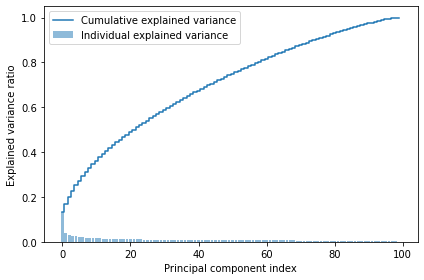

In [24]:
from sklearn.decomposition import PCA


#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
pca.fit(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(
    range(0, len(exp_var_pca)),
    exp_var_pca,
    alpha=0.5,
    align="center",
    label="Individual explained variance",
)
plt.step(
    range(0, len(cum_sum_eigenvalues)),
    cum_sum_eigenvalues,
    where="mid",
    label="Cumulative explained variance",
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [25]:
pca = PCA(n_components=20).fit(X_train_std)

X_pca = pca.transform(X)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

              precision    recall  f1-score   support

       drink       0.41      0.42      0.41       410
        food       0.45      0.48      0.46       393
    interior       0.38      0.47      0.42       392
        menu       0.80      0.68      0.73       401
     outside       0.54      0.45      0.49       404

    accuracy                           0.50      2000
   macro avg       0.52      0.50      0.51      2000
weighted avg       0.52      0.50      0.51      2000



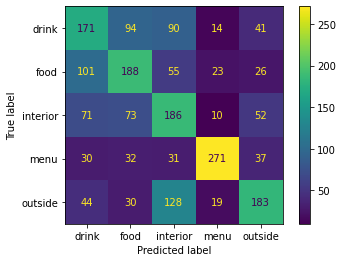

In [26]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier().fit(X_train_pca, y_train)

y_pred = knn.predict(X_test_pca)


from sklearn.metrics import plot_confusion_matrix, classification_report

print(classification_report(y_test, y_pred))

plot_confusion_matrix(knn, X_test_pca, y_test)


In [27]:

from sklearn.neighbors import NearestNeighbors


# Create a nearest neighbor classifier
nbrs = NearestNeighbors(n_neighbors=2).fit(
    X_pca
)


# Compute the distances between the query image and all images
distances, indices = nbrs.kneighbors(X_pca)


3862
-------------------------------------------------------------------------
❌ Query prediction incorrect: outside (pred) vs. food (true)
Query image predicted labels:
   drink  food  interior  menu  outside
0    0.0   0.0       0.0   0.4      0.6
-------------------------------------------------------------------------
✅ Nearest image prediction correct: outside
Nearest image predicted labels:
   drink  food  interior  menu  outside
0    0.0   0.0       0.0   0.4      0.6
-------------------------------------------------------------------------
❌ Query image and nearest image have different labels: food (query) vs. outside (nearest)
-------------------------------------------------------------------------


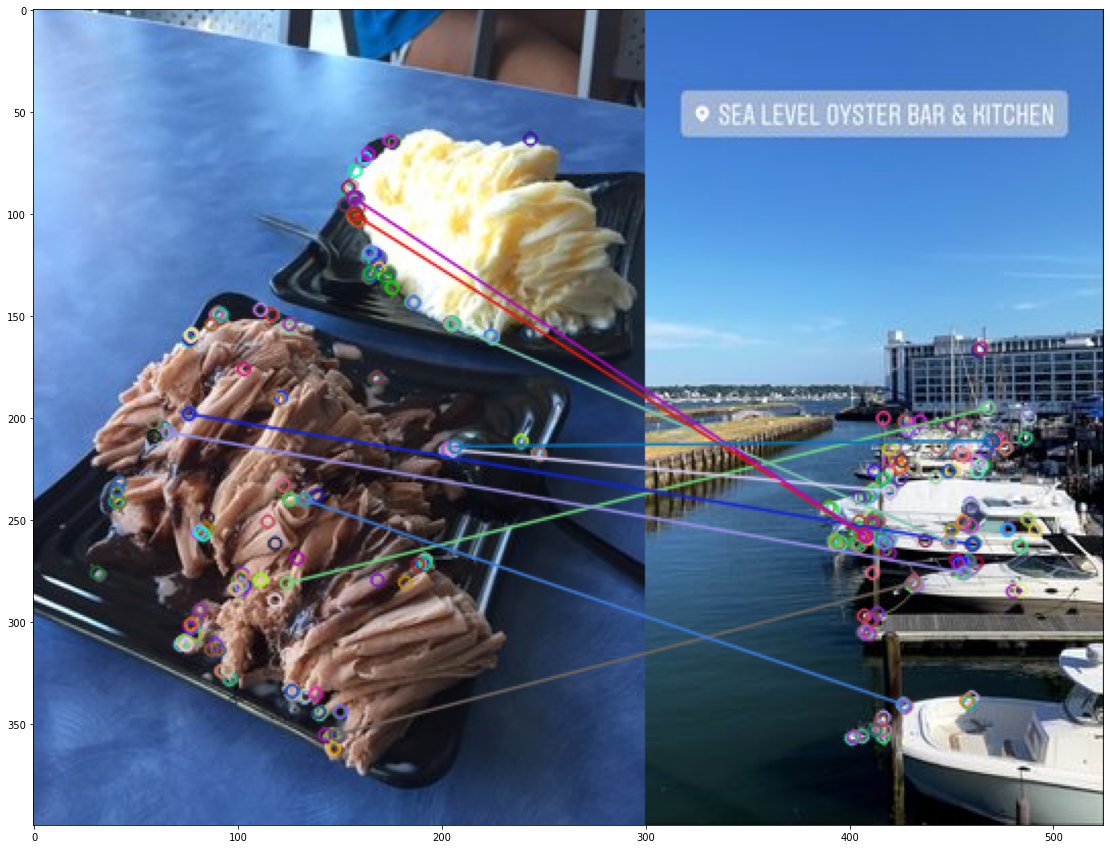

In [48]:
import random


query_index = random.randint(0, len(photos_features_df) - 1)
print(query_index)
nn_index = indices[query_index][1]

query_photo = photos_features_df.iloc[query_index]
query_img_path = os.path.join(
    "../data/raw/academic/photos", query_photo["file_name"] + ".jpg"
)
query_img = cv.cvtColor(
    cv.imread(query_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)
query_pred_proba = knn.predict_proba(X_pca[query_index].reshape(1, -1))
query_pred = knn.predict(X_pca[query_index].reshape(1, -1))[0]
query_true = y[query_index]

print(
    "-------------------------------------------------------------------------"
)

if query_true == query_pred:
    print(f"✅ Query prediction correct: {query_pred}")
else:
    print(
        f"❌ Query prediction incorrect: {query_pred} (pred) vs. {query_true} (true)"
    )

print(
    f"Query image predicted labels:\n{pd.DataFrame(query_pred_proba, columns=knn.classes_)}"
)

print(
    "-------------------------------------------------------------------------"
)

nn_photo = photos_features_df.iloc[nn_index]
nn_img_path = os.path.join(
    "../data/raw/academic/photos", nn_photo["file_name"] + ".jpg"
)
nn_img = cv.cvtColor(
    cv.imread(nn_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB
)
nn_pred_proba = knn.predict_proba(X_pca[nn_index].reshape(1, -1))
nn_pred = knn.predict(X_pca[nn_index].reshape(1, -1))[0]
nn_true = y[nn_index]

if nn_true == nn_pred:
    print(f"✅ Nearest image prediction correct: {nn_pred}")
else:
    print(
        f"❌ Nearest image prediction incorrect: {nn_pred} (pred) vs. {nn_true} (true)"
    )

print(
    f"Nearest image predicted labels:\n{pd.DataFrame(nn_pred_proba, columns=knn.classes_)}"
)

print(
    "-------------------------------------------------------------------------"
)

if query_true == nn_true:
    print(f"✅ Query image and nearest image have same label: {query_true}")
else:
    print(
        f"❌ Query image and nearest image have different labels: {query_true} (query) vs. {nn_true} (nearest)"
    )

print(
    "-------------------------------------------------------------------------"
)

kp1 = photos_features_df.loc[query_index, "orb_keypoints"]
des1 = photos_features_df.loc[query_index, "orb_descriptors"]
kp2 = photos_features_df.loc[nn_index, "orb_keypoints"]
des2 = photos_features_df.loc[nn_index, "orb_descriptors"]


# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(
    query_img,
    kp1,
    nn_img,
    kp2,
    good,
    None,
    # flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
fig = plt.figure(figsize=(20, 15))
plt.imshow(img3)
plt.show()
